# Open and run analysis on multiple polygons <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Many users need to run analyses on their own areas of interest. 
A common use case involves running the same analysis across multiple polygons in a vector file (e.g. ESRI Shapefile or GeoJSON). 
This notebook will demonstrate how to use a vector file and the Open Data Cube to extract satellite data from Digital Earth Australia corresponding to individual polygon geometries.

## Description
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

We can retrieve data for each polygon, perform an analysis like calculating NDVI and plot the data.

1. First we open the vector file as a `geopandas.GeoDataFrame`
2. Iterate through each polygon in the `GeoDataFrame`, and extract satellite data from DEA
3. Calculate NDVI as an example analysis on one of the extracted satellite timeseries
4. Plot NDVI for the polygon extent

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand.

In [1]:
%matplotlib inline

import sys

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.crs
import rioxarray
from datacube.utils import geometry

sys.path.append("../Scripts")
import functools
import os
import pickle

import datacube.utils.cog

# import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import matplotlib.cm
import matplotlib.colors

# import matplotlib.pyplot as plt
import numpy as np
import odc.ui
import rasterio.features
import rioxarray
import skimage.color as colour
import skimage.io
import sklearn.metrics
import xarray as xr

# import sys
# import datacube
from datacube.storage.masking import make_mask

# from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_coastaltools import tidal_stats, tidal_tag
from dea_dask import create_local_dask_cluster
from dea_datahandling import array_to_geotiff, load_ard
from dea_plotting import display_map, map_shapefile, rgb
from dea_spatialtools import xr_rasterize
from dea_temporaltools import time_buffer
from IPython.display import display
from odc.ui import with_ui_cbk
from shapely.geometry import shape, Polygon
from tqdm.notebook import tqdm

# %matplotlib widget

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

import matplotlib.gridspec as gridspec

import matplotlib as mpl

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data.

In [ ]:
dc = datacube.Datacube(app="Analyse_multiple_polygons")
create_local_dask_cluster()

# *Load predetermined polygons and select a region of interest*

In [ ]:
## User defines path to polygon vector file, file name and 
## the column name for unique integer identifiers for each vector object.
%cd '/home/jovyan/dev/dea-notebooks/Claire/'
vector_file = "QISMCQ_polygons.shp"
attribute_col = "id"

In [ ]:
# Read in the polygon vector file
gdf_master = gpd.read_file(vector_file)

# Set the crs to match the imagery data retrieved
gdf_master.to_crs(epsg=3577, inplace=True)

# #  View the unique classes
# print(gdf_master["BRD_HAB"].unique())

#  Drop unrequired classes
gdf_master = gdf_master.drop(
    gdf_master[
        (gdf_master.BRD_HAB == 'Subtidal consolidated substrate')
        | (gdf_master.BRD_HAB == 'Intertidal consolidated substrate')
        | (gdf_master.BRD_HAB == 'Intertidal coral')
        | (gdf_master.BRD_HAB == 'Subtidal coral')
        | (gdf_master.BRD_HAB == 'Subtidal unconsolidated substrate')
        | (gdf_master.BRD_HAB == "Intertidal unconsolidated substrate")
        | (gdf_master.BRD_HAB == 'Intertidal algae')
        | (gdf_master.BRD_HAB == 'Subtidal seagrass')
        | (gdf_master.BRD_HAB == 'Subtidal algae')
    ].index
)

#  Reset the index of the gdf to infill dropped values
gdf_master.reset_index(inplace=True)

#  Check that correct classes remain
print(gdf_master["BRD_HAB"].unique())

# Attribute each class with an integer value
val = (gdf_master["BRD_HAB"].unique()).tolist()

num_list = []
attr_key = []

d = 0
for x in range(len(gdf_master)):
    for d in range(len(val)):
        if gdf_master["BRD_HAB"].values[x] == str(val[d]):
            num_list.append(d)
        # Create a key to interpret the integer attribute for each class
        for y in num_list:
            if y not in attr_key:
                attr_key.append(y)

val = [[el] for el in val]
for x in attr_key:
    val[x].append(attr_key[x])


print("The attribute values for each class are as follows: " + str(val))

# Update the geodataframe of vector polygons with the integer attribution for each class
gdf_master["id"] = num_list

# Map the shapefiles from imported vector set
roi = map_shapefile(gdf_master, attribute=attribute_col)

In [ ]:
'''
After identifying an analysis region of interest(roi) on the map,
intersect the roi with the master polygon gdf from which imagery 
will be extracted. Note that when multiple areas are drawn on the
map above, it is the final roi that is used for analysis in the 
following cells
'''

##  Form a shapely polygon from the coordinates defined by the user on the map
polygon_roi = Polygon(roi[-1]['geometry']['coordinates'][0])

##  Generate a new geodataframe containing the user defined polygon geometry
newdf = gpd.GeoDataFrame(gpd.GeoSeries(polygon_roi), columns=['geometry'], crs='EPSG:4326')
newdf = newdf.to_crs(gdf_master.crs)

##  Intersect the user-defined region of interest with the master
##  to create the working gdf from which imagery will be extracted
gdf = gpd.overlay(gdf_master, newdf, how='intersection')
print('This selection includes ', len(gdf), ' individual polygons')
gdf.plot()


# Load imagery for the region of interest

*user to define time-period of interest in the query*

In [ ]:
# Setup the general query and variables for later
products = ["ga_ls8c_ard_3"]
align = (0, 0)

# Query
query = {
    "time": ("2013-01-01", "2021-01-01"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
    "output_crs": "EPSG:3577", # Do not change th
    "resolution": (-30, 30),
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
}

# Designate dask chunks
# It doesn't really matter how big the chunks we load are, as long as time ~ 1.
chunks = {"time": 1, "x": 3000, "y": 3000}

# Load data for predetermined polygons
# Dictionary to save results
results = {}

'''List of saved tideposts. In the event that a polygon centroid geometry fails
to return an associated tideheight, the tidal_tag function will bring in this list
and use the most recent successful polygon centroid geometry to calculate a tideheight
for the current polygon'''
tideposts = [[0,0]]

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():

    print(f"Feature: {index + 1}/{len(gdf)}")
    print(gdf["BRD_HAB"].values[index])
    print(str(index))
    print(str(row))

    if not (str(row[attribute_col]) in results.keys()):
        results[str(row[attribute_col])] = {}

    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf.crs)

    # Update the query to include our geopolygon
    query.update({"geopolygon": geom})

    # Load landsat
    ds = load_ard(
        dc=dc,
        products=products,
        min_gooddata=0.99,  # only take uncloudy scenes
        ls7_slc_off=False,
        **query,
    )

    ## Tidally tag datasets
    ds, tidepost_lon, tidepost_lat = tidal_tag(ds,
                                               tideposts[-1],
                                               return_tideposts=True,
                                               ebb_flow=True)
    tideposts.append([tidepost_lon, tidepost_lat])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)

    # Append results to a dictionary using the attribute
    # column as an key
    results[str(row[attribute_col])][str(index)] = ds

    print(row[attribute_col], index)
    print("----------------------")

## Filter results by tide height

*user to define tide_range to keep - set the desired quantile value in `lowest_20` variable*

In [ ]:
# Create a second dictionary that contains only datasets filtered by nominated tide range
##  Can this be absorbed into the data loading step above? Filtered before data loading to speed up the workflow?

results2 = {}

for k in results:

    if not (str(k) in results2.keys()):
        results2[str(k)] = {}

    for kk in results[k]:
        ds = results[k][kk]  
        lowest_20 = ds.tide_height.quantile([0.20]).values  ### Need a workaround for this as lowest 20% is 
        #calculated per ds and wont be consistent across all observations. However, perhaps this isn't a problem??
        results2[k][kk] = ds.where(ds.tide_height <= lowest_20, drop=True)

print ('Class name, class id and number of records:')        
for k in results2.keys():
    print(val[int(k)], len(results2[k]))

### Plot an RGB image     -     needs debugging
We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot:

In [ ]:
# class_key = '0'
# # print (results[class_key].keys())
# polygon_index_key = '0'

# # To show the results of a single polygon:

# # Would be useful to see the outline of the whole polygon to compare pixel retrievals

# rgb(results2[class_key][polygon_index_key], col='time', size=4)
# rgb(results2['1'][polygon_index_key], col='time', size=4)

'''-----------------------------------------------------------------'''

# ##  To show the results for every polygon in a given class:

# ##  Would be useful to see the outline of the whole polygon to compare pixel retrievals

# for k in results2[class_key]: ### WARNING: this opens too many figures and may overwhelm the memory
#     rgb(results2[class_key][k], col = 'time')#, size=4)

### Calculate indices and complete data load

*user defines required indices in the `calculate_indices` function call*

In [ ]:
# For 'results2' ds (low tide imagery only), calculate indices for all pixels inside each polygon then 
# calculate a zonal stat for the polygon
# This code works for a single time step for each polygon


for k in results2:
        
    for kk in results2[k]:
        
        results2[k][kk] = results2[k][kk].compute() ## WARNING: very time consuming step!       
        ds = results2[k][kk]
       
        # To work around the calculate_indices function which was stalling on the additional 
        # coastal variables, drop tide_height and ebb_flow variables
        tide_height = ds['tide_height']
        ebb_flow = ds['ebb_flow']
        ds = ds.drop_vars(names = ('tide_height', 'ebb_flow'))
        
        # calculate ndvi for pixels inside the polygon
        ds = calculate_indices(ds, index=['NDVI', 'MNDWI', 'NDAVI', 'WAVI', 'EVI', 'SAVI'], 
                               collection='ga_ls_3', inplace=True)

        results2[str(k)][str(kk)] = xr.merge([results2[str(k)][str(kk)], ds])

# Save loaded results
*By default, save the imagery and polygon sub-sampled datasets every time.*

*If required to load last dataset, hash out the `save` calls and unhash the `load` calls*

In [2]:
## Save variables

## Save imagery dict
with open('results2_' + query['time'][0] +'.pickle', 'wb') as handle:
    pickle.dump(results2, handle)
 
## Save polygon gdf   
with open('gdf_' + query['time'][0] +'.pickle', 'wb') as handle:
    pickle.dump(gdf, handle)
    
'''-----------------------------------------'''

# ## Load saved variables (hashed out by default)

# ## Re-load the query

# # Setup the general query and variables for later
# products = ["ga_ls8c_ard_3"]
# align = (0, 0)

# # Query
# query = {
#     "time": ("2013-01-01", "2020-08-01"),
#     "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
#     "output_crs": "EPSG:3577", # Do not change th
#     "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
# }

# ## ensure that you are working from the same directory as the files are stored
# %cd '/home/jovyan/dev/dea-notebooks/Claire'

# ## Load imagery dict
# with open('results2_' + query['time'][0] +'.pickle', 'rb') as handle:
#     results2 = pickle.load(handle)

# ## Load polygon gdf    
# with open('gdf_' + query['time'][0] +'.pickle', 'rb') as handle:
#     gdf = pickle.load(handle)




/home/jovyan/dev/dea-notebooks/Claire


# Data Analysis

Load the following cell to define the functions that enable data interrogation and visualisation

In [147]:
### funcs for py script

def coastal_wit(gdf,
               results3,
               pg,
               drop=False,
               pc_drop=0,
               px_min=0,
               water=True):
    """
    Takes a polygon of interest (pg) from the gdf of polygon shapefiles and extracts and plots 
    the frequency of pixels as assigned into class ranges of NDVI. Also includes pixels identified
    as wet. All NDVI pixels are masked by 'dry' range of MNDWI.
    If conditional dataset dropping is required, set drop=True and nominate the percent of wet pixels
    tolerated and the minimum number of allowable pixels (e.g. pc_drop=90 means drop any timestep dataset
    when more than 90% of pixels are wet; px_min=5 means that a timestep dataset will only be dropped
    when more than pc_drop pixels are wet AND the remaining pixels sum to less than or = px_min - or
    5 in this case)
    By default, water is included in the plot. If water suppression is required, set water=False.
    """
    
    if water:
        ##  Data prep for WIT prototype (automated for all timesteps for all polygons)

        ##  Generate all datasets for the stacked line plot (WIT) by adding as variables to results dataset
        for k in results3:
            for kk in results3[k]: 

                ##  Add a non-water pixel mask variable
                results3[k][kk]['mask'] = results3[k][kk].MNDWI <= 0

                ##  Generate the MNDWI_water class
                results3[k][kk]['mndwi_water'] = results3[k][kk].MNDWI > 0

                ##  Generate NDVI classes

                ##  NDVI less than 0.1
                results3[k][kk]['unveg'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI < 0.1).astype(int))

                ##  NDVI 0.1 to 0.33
                results3[k][kk]['ndvi_low'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.1).astype(int) & (results3[k][kk].NDVI < 0.333).astype(int))

                ##  NDVI 0.33 to 0.66
                results3[k][kk]['ndvi_mid'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.333).astype(int) & (results3[k][kk].NDVI < 0.666).astype(int))

                ### NDVI 0.66 to 1
                results3[k][kk]['ndvi_high'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.666).astype(int) & (results3[k][kk].NDVI <= 1).astype(int))

                ##  Mask the NDVI classes to show non-water pixels only
                results3[k][kk]['unveg'] = results3[k][kk]['unveg'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_low'] = results3[k][kk]['ndvi_low'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_mid'] = results3[k][kk]['ndvi_mid'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_high'] = results3[k][kk]['ndvi_high'].where(results3[k][kk]['mask'])


        ##  Automated: Create a new gdf to record the landcover types/pixel counts per timestep for a single polygon and normalise for plotting
        ##  Extract the pixel counts and normalise, in preparation for plotting

        ## From the results2 dataset, the temporal values for the nominated polygon are stored in the following dataset of the resutls2 dict:
        ## class key
        cl = gdf.loc[gdf['index'] == pg].id.values.item()
        ## class polygon
        pg1 = gdf.loc[gdf['index'] == pg].index.values.item()

        ## Set up lists to extract pixel counts per timestep into
        ls_pixels = []
        ls_mndwi = []
        ls_unveg = []
        ls_ndvilow = []
        ls_ndvimid = []
        ls_ndvihigh = []
        ls_pxsum = []
        ls_tide = []

 ##  Populate pixel count lists per class per timestep
        for t in range (0, len(results3[str(cl)][str(pg1)].time)):
            ls_pixels.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).nbart_red)))
            ls_mndwi.append(np.count_nonzero(results3[str(cl)][str(pg1)].isel(time=t).mndwi_water))
            ls_unveg.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).unveg)))
            ls_ndvilow.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_low)))
            ls_ndvimid.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_mid)))
            ls_ndvihigh.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_high)))
            ls_pxsum.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).nbart_red)))
            ls_tide.append(results3[str(cl)][str(pg1)].isel(time=t).tide_height.median().values)

        ##  Generate a dataframe summarising class pixel counts per timestep
        classes_df = pd.DataFrame(
                    {"pixels": ls_pixels,
                    "water": ls_mndwi,
                    "unveg": ls_unveg,
                    "ndvi_low": ls_ndvilow,
                    "ndvi_mid": ls_ndvimid,
                    "ndvi_high": ls_ndvihigh,
                    "px_sum": ls_pxsum,
                    "tide_height": ls_tide},
                    index = results3[str(cl)][str(pg1)].time.values
                    )

        ##  Normalise pixel counts per class per timestep
        classes_df['pc_water'] = classes_df['water']/classes_df['pixels']*100
        classes_df['pc_unveg'] = classes_df['unveg']/classes_df['pixels']*100
        classes_df['pc_ndvi_low'] = classes_df['ndvi_low']/classes_df['pixels']*100
        classes_df['pc_ndvi_mid'] = classes_df['ndvi_mid']/classes_df['pixels']*100
        classes_df['pc_ndvi_high'] = classes_df['ndvi_high']/classes_df['pixels']*100
        classes_df['pc_total'] = classes_df['pc_water']+classes_df['pc_unveg']+classes_df['pc_ndvi_low']+classes_df['pc_ndvi_mid']+classes_df['pc_ndvi_high']
        classes_df['pc_exposedpx'] = (classes_df['unveg']+classes_df['ndvi_low']+
                                  classes_df['ndvi_mid']+classes_df['ndvi_high'])/classes_df['px_sum']*100


        if drop:
            ##  Conditions on which to drop rows
            drop_records = classes_df[(classes_df['pc_water'] >= pc_drop) & 
                          (classes_df['pc_unveg']+
                           classes_df['pc_ndvi_low']+
                           classes_df['pc_ndvi_mid']+
                           classes_df['pc_ndvi_high'] <= px_min)].index

            ##  Apply conditions to df by dropping values
            classes_df.drop(drop_records, inplace=True)

    if not water:
                ##  Generate all datasets for the stacked line plot (WIT) by adding as variables to results dataset
        for k in results3:
            for kk in results3[k]: 

                ##  Add a non-water pixel mask variable
                results3[k][kk]['mask'] = results3[k][kk].MNDWI <= 0

                ##  Generate the MNDWI_water class
                results3[k][kk]['mndwi_water'] = results3[k][kk].MNDWI > 0

                ##  Generate NDVI classes

                ##  NDVI less than 0.1
                results3[k][kk]['unveg'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI < 0.1).astype(int))

                ##  NDVI 0.1 to 0.33
                results3[k][kk]['ndvi_low'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.1).astype(int) & (results3[k][kk].NDVI < 0.333).astype(int))

                ##  NDVI 0.33 to 0.66
                results3[k][kk]['ndvi_mid'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.333).astype(int) & (results3[k][kk].NDVI < 0.666).astype(int))

                ### NDVI 0.66 to 1
                results3[k][kk]['ndvi_high'] = results3[k][kk].NDVI.where(
                    (results3[k][kk].NDVI >= 0.666).astype(int) & (results3[k][kk].NDVI <= 1).astype(int))

                ##  Mask the NDVI classes to show non-water pixels only
                results3[k][kk]['unveg'] = results3[k][kk]['unveg'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_low'] = results3[k][kk]['ndvi_low'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_mid'] = results3[k][kk]['ndvi_mid'].where(results3[k][kk]['mask'])
                results3[k][kk]['ndvi_high'] = results3[k][kk]['ndvi_high'].where(results3[k][kk]['mask'])


        ##  Automated: Create a new gdf to record the landcover types/pixel counts per timestep for a single polygon and normalise for plotting
        ##  Extract the pixel counts and normalise, in preparation for plotting

        ## From the results2 dataset, the temporal values for the nominated polygon are stored in the following dataset of the resutls2 dict:
        ## class key
        cl = gdf.loc[gdf['index'] == pg].id.values.item()
        ## class polygon
        pg1 = gdf.loc[gdf['index'] == pg].index.values.item()

        ## Set up lists to extract pixel counts per timestep into
        ls_pixels = []
        # ls_mndwi = []
        ls_unveg = []
        ls_ndvilow = []
        ls_ndvimid = []
        ls_ndvihigh = []
        ls_pxsum = []
        ls_tide = []

        ##  Populate pixel count lists per class per timestep
        for t in range (0, len(results3[str(cl)][str(pg1)].time)):
            ls_pixels.append((np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).nbart_red))) - 
                              (np.count_nonzero(results3[str(cl)][str(pg1)].isel(time=t).mndwi_water)))
        #     ls_mndwi.append(np.count_nonzero(results3[str(cl)][str(pg1)].isel(time=t).mndwi_water))
            ls_unveg.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).unveg)))
            ls_ndvilow.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_low)))
            ls_ndvimid.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_mid)))
            ls_ndvihigh.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).ndvi_high)))
            ls_pxsum.append(np.count_nonzero(~np.isnan(results3[str(cl)][str(pg1)].isel(time=t).nbart_red)))
            ls_tide.append(results3[str(cl)][str(pg1)].isel(time=t).tide_height.median().values)

        ##  Generate a dataframe summarising class pixel counts per timestep
        classes_df = pd.DataFrame(
                    {"pixels": ls_pixels,
        #             "water": ls_mndwi,
                    "unveg": ls_unveg,
                    "ndvi_low": ls_ndvilow,
                    "ndvi_mid": ls_ndvimid,
                    "ndvi_high": ls_ndvihigh,
                    "px_sum": ls_pxsum,
                    "tide_height": ls_tide},
                    index = results3[str(cl)][str(pg1)].time.values
                    )

        ##  Normalise pixel counts per class per timestep
        # classes_df['pc_water'] = classes_df['water']/classes_df['pixels']*100
        classes_df['pc_unveg'] = classes_df['unveg']/classes_df['pixels']*100
        classes_df['pc_ndvi_low'] = classes_df['ndvi_low']/classes_df['pixels']*100
        classes_df['pc_ndvi_mid'] = classes_df['ndvi_mid']/classes_df['pixels']*100
        classes_df['pc_ndvi_high'] = classes_df['ndvi_high']/classes_df['pixels']*100
        classes_df['pc_total'] = (classes_df['pc_unveg']+classes_df['pc_ndvi_low']+
                                  classes_df['pc_ndvi_mid']+classes_df['pc_ndvi_high'])#+classes_df['pc_water']
        classes_df['pc_exposedpx'] = (classes_df['unveg']+classes_df['ndvi_low']+
                                          classes_df['ndvi_mid']+classes_df['ndvi_high'])/classes_df['px_sum']*100


        drop_records = classes_df[(classes_df['pixels'] == 0)].index

        ##  Apply conditions to df by dropping values
        classes_df.drop(drop_records, inplace=True)
        
        if drop:
            ##  Conditions on which to drop rows
            drop_records = classes_df[(classes_df['pc_water'] >= pc_drop) & 
                          (classes_df['pc_unveg']+
                           classes_df['pc_ndvi_low']+
                           classes_df['pc_ndvi_mid']+
                           classes_df['pc_ndvi_high'] <= px_min)].index

            ##  Apply conditions to df by dropping values
            classes_df.drop(drop_records, inplace=True)
    return classes_df

def onclick_timeseries(event):
    '''
    This widget allows the user to select a time point from a plotted time series. 
    It then translates the chosen point back into the approriate datetime object so
    that it can be used to find the location of this time point within the extracted
    datasets. The index location of this time step is also returned. 
    
    '''
    global time_slice, TimeIndex, pixelx, pixely
    
    # Get time from x axis of plot 
    timeOfInterest = event.xdata
    
    # Get x and y coordinates from click
    pixelx, pixely = int(event.xdata), int(event.ydata)
    
    # Add point to image
    plt.plot(pixelx, pixely, 'ro', markersize=5)
    
    # Convert clicked int to datetime format
    time_slice = matplotlib.dates.num2date(timeOfInterest).date()
    
    # Convert clicked value to str
    time_slice = str(time_slice)
    
    # Convert clicked value to correct datetime format
    time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
    
    # Find the time index of the chosen time slice
    TimeIndex = results3[str(cl)][str(pg1)].indexes['time'].get_loc(time_slice, method='nearest')
    
    # Print the date of the image closest to clicked pixel
    ClosestImage = results3[str(cl)][str(pg1)].time[TimeIndex].values
    
    # Update text below plot
    w2.value = 'Closest imagery date : {}'.format(ClosestImage)
    
# For every polygon, extract list pairs for each polygon pixel of the temporal mean and std of the nominated indice

def px_heatmap (results2, index_ls):

    ## New dict to store arrays
    pxsummary = {}

    ## Master gdf
    df_pxsummary = gpd.GeoDataFrame()
    df_pxsummary['geometry'] = None

    ## List to store geom, unique pixel id 
    # pxid = []
    uniquepx = []
    pxgeom = []

    ##  Generate a list of keys for polygons in class '0' of results2
    keylist = list(results2['0'].keys())


    ##  Generate zonal indice stats for polygon followed by temporal statistic
    ##  Append polygon id and temporal statistic to gdf
    for k in results2:

        if not (str(k) in pxsummary.keys()):
            pxsummary[str(k)] = {}

        for kk in results2[k]:

            lon = []
            for value in results2[k][kk].x.values:
                lon.append(value)

            lat = []
            for value in results2[k][kk].y.values:
                lat.append(value)

            ds = xr.Dataset()

            ##  For each nominated indice:
            for var in index_ls:
                if var in results2["0"][keylist[0]].var():

                    temporalmean = (results2[str(k)][str(kk)][var].mean(dim='time'))
                    name1 = str(var) + ' mean'
                    ds[name1] = (('y', 'x'), temporalmean)

                    temporalstd = (results2[k][kk][var].std(dim='time'))
                    name2 = str(var) + ' std'
                    ds[name2] = (('y', 'x'), temporalstd)

            ds.coords['lon'] = ('x'), lon
            ds.coords['lat'] = ('y'), lat

            ## Extract pixel geometry/shape for input into gdf for choropleth plotting
            # Extract dataset matching polygon
            closest_ds = results2[k][kk]

            ## Skip empty arrays
            if closest_ds.x.size == 0:
                print('Empty arrays: k: ', k, 'kk: ', kk)
                continue
            else:       
                # Input array (based on red band) to segment and vectorise
                input_array = closest_ds.nbart_red
                input_transform = closest_ds.affine  
                input_crs = input_array.crs

                # Create array with a unique value per cell
                unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

                # Vectorise each unique feature in array
                vectors = rasterio.features.shapes(
                    source=unique_pixels.astype(np.int16), transform=input_transform
                )

                # Extract polygons and values from generator
                vectors = list(vectors)
                values = [value for polygon, value in vectors]
                polygons = [shape(polygon) for polygon, value in vectors]
                pp = np.array(polygons)
                pp = pp.reshape(len(input_array.y), len(input_array.x))

        #         # Create a geopandas dataframe populated with the polygon shapes
        #         closestdate_poly_gdf = gpd.GeoDataFrame(data={"id": values}, geometry=polygons, crs=input_crs)

                ds['geometry'] = (('y', 'x'), pp)

            results2[k][kk]['geometry'] = (('y', 'x'), pp)
            results2[k][kk].set_coords('geometry')

            
            ## Append [geom, unique pixel id] to list for later addition to gdf, merging on geom
            ## CHECK THAT THE X'S AND Y'S ARE THE CORRECT WAY AROUND FOR MERGING LATER ON
            pxid2 = []
            
            for x in ds['x']:
                for y in ds['y']:
                    pxid1 = str(k)+str(kk)+str(ds['y'][y].item())+str(ds['x'][x].item())
                    gm = pp[ds['y'][y].item()][ds['x'][x].item()]
    #                 pxid.append([pxid1, gm])
                    uniquepx.append(pxid1)
                    pxgeom.append(gm)
                    pxid2.append(pxid1)
            
            pxid2 = np.array(pxid2).reshape(ds.y.shape[0], ds.x.shape[0])
            results2[k][kk]['pxid'] = (('y', 'x'), pxid2)
                
            pxsummary[k][kk] = ds

#             uniquepx1 = (np.array(uniquepx)).reshape(ds.y.values, ds.x.values)
#             results2[k][kk]['pxid'] = (('y', 'x'), uniquepx1)

            ## Append ds to df_pxsummary
            ds = ds.to_dataframe()
            df_pxsummary = df_pxsummary.append(ds)
            df_pxsummary.crs = gdf.crs

    # pxsummary

    pxid = gpd.GeoDataFrame(uniquepx, geometry=pxgeom, columns=['pxid'], crs=input_crs)

    df_pxsummary.reset_index(inplace=True)

    df_pxsummary1 = df_pxsummary.merge(pxid)
    df_pxsummary1.set_index('pxid', inplace=True, drop=False)
    df_pxsummary1.dropna(axis=0, inplace=True)
    df_pxsummary1.sort_index(level='pxid', inplace=True)

    return df_pxsummary1, pxsummary, results2

# For every polygon, extract list pairs on the polygon id and temporal mean and std of the nominated indice
def zonal (results2, index_ls, gdf):
    ##  Generate a list of keys for polygons in class '0' of results2
    keylist = list(results2['0'].keys())

    ##  For each nominated indice:
    for var in index_ls:
        if var in results2["0"][keylist[0]].var():

            lsmean = []
            lsstd = []

            ##  Generate zonal indice stats for polygon followed by temporal statistic
            ##  Append polygon id and temporal statistic to gdf
            for k in results2:

                for kk in results2[k]:
                    temporalmean = (results2[k][kk][var].mean('y').mean('x')).mean()
                    lsmean.append([int(kk), temporalmean.values])

                    temporalstd = (results2[k][kk][var].std('y').std('x')).std()
                    lsstd.append([int(kk), temporalstd.values])                

            ##  Sort the list by polygon id to match up to the original polygon gdf
            lsmean = sorted(lsmean)
            lsstd = sorted(lsstd)

            ##  Separate the sorted polygon ids from the indice statistic to build into a pd.DataFrame
            indicemean = []
            indicestd = []
            polyid = []

            for x in lsmean:
                polyid.append(x[0])
                indicemean.append(x[1])

            for x in lsstd:
                indicestd.append(x[1])

            # Build a pd.DataFrame from the sorted polygon id and indice statistics. Nominate a name for the new column.
            indexstats = pd.DataFrame(
                indicemean, index=polyid, columns=[str(var) + " mean"]
            )
            indexstats[str(var) + " std"] = None
            indexstats.loc[polyid, (str(var) + " std")] = indicestd

            # Workaround to handle automatic addition of key_0 column at merge step
            if "key_0" in gdf.columns:
                gdf.drop(columns=["key_0"], inplace=True)

            # # Merge the indice statistic for each polygon into the original polygon gdf
            gdf = gdf.merge(indexstats, on=indexstats.index)
            
            return gdf

## Generate zonal and temporal stats for each polygon

In [4]:
##  Spectral indices available in the `calculate_indices` function (dea_bandindices.py)
index_ls = [
    "NDVI",
    "EVI",
    "NDAVI",
    "WAVI",
    "LAI",
    "SAVI",
    "MSAVI",
    "NDMI",
    "NBR",
    "BAI",
    "NDCI",
    "NDSI",
    "NDTI",
    "NDWI",
    "MNDWI",
    "NDBI",
    "BUI",
    "BAEI",
    "NBI",
    "BSI",
    "AWEI_ns",
    "AWEI_sh",
    "WI",
    "TCW",
    "TCG",
    "TCB",
    "CMR",
    "FMR",
    "IOR",
]

In [5]:
## Generate zonal stats and attach to class polygons
gdf=zonal(results2, index_ls, gdf)

## View the zonal statistics temporal summaries

In [6]:
##  Create new gdf's for each class to plot
grasses = gdf.drop(
    gdf[gdf.BRD_HAB != "Intertidal grass-herb-sedge-other succulent"].index
)
mangroves = gdf.drop(
    gdf[gdf.BRD_HAB != "Intertidal mangroves and other trees & shrubs"].index
)
seagrass = gdf.drop(gdf[gdf.BRD_HAB != "Intertidal seagrass"].index)

##  Drop polygons containing NaN values
##  ASSUMPTION: if NDVI contains NaNs, all indices will contain NaNs. 
##  ToDo: write a loop or func that looks for NaNs in any of the supplied indices
grasses = grasses.dropna(subset=['NDVI mean', 'NDVI std'])
mangroves = mangroves.dropna(subset=['NDVI mean', 'NDVI std'])
seagrass = seagrass.dropna(subset=['NDVI mean', 'NDVI std'])

In [7]:
##  Plot grasses
print('Select attribute from: ', gdf.columns)
map_shapefile(grasses, attribute="NDVI std", continuous=True)

Select attribute from:  Index(['key_0', 'index', 'OBJECTID', 'CONSOL', 'DOM_TYPE', 'DOM_LABEL',
       'CO_TYPES', 'TIDE_ZONE', 'BRD_HAB', 'Shape_Leng', 'Shape_Area', 'id',
       'geometry', 'NDVI mean', 'NDVI std'],
      dtype='object')


Map(center=[-24.07954240899994, 151.54224430350007], controls=(ZoomControl(options=['position', 'zoom_in_text'…

[]

In [8]:
##  Plot mangroves
map_shapefile(mangroves, attribute="NDVI std", continuous=True)

Map(center=[-24.080383735999984, 151.54029527350008], controls=(ZoomControl(options=['position', 'zoom_in_text…

[]

In [9]:
##  Plot seagrass
map_shapefile(seagrass, attribute="NDVI mean", continuous=True)

Map(center=[-24.068313969499943, 151.5403206515001], controls=(ZoomControl(options=['position', 'zoom_in_text'…

[]

##  Per polygon spatiotemporal analysis

For a user defined polygon (search the maps above to identify polygon/s of interest), show a stacked bar graph (WIT style)
that groups the pixels in the polygon into major classes/cover types.


In [10]:
## for code development only: update to `results2` upon successful workflow
## TODO: code successful. Update code to use `results2` variable and remove `results3` variable

results3 = results2.copy()

results2 == results3

True

In [11]:
##  ******From the interactive zonal summary plots above, IDENTIFY A POLYGON to interrogate*******
pg = 3635

cl = gdf.loc[gdf['index'] == pg].id.values.item()
## class polygon
pg1 = gdf.loc[gdf['index'] == pg].index.values.item()

# Plot interactive WIT

In [12]:
## Coastal_wit func call
classes_df = coastal_wit(gdf=gdf,
               results3=results3,
               pg=pg, 
               water=True, 
               drop=False,
               pc_drop=80,
               px_min=20)     


##  Duplicated cell interactive stacked plot
%matplotlib widget
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["light green"],
       sns.xkcd_rgb["green"],
       sns.xkcd_rgb["dark green"]]

plt.clf()
plt.close(fig=None)

fig = plt.figure(figsize=(12,8), constrained_layout=True)
gs = fig.add_gridspec(8,1)

ax1 = fig.add_subplot(gs[0:2, :])
ax1.set_title('% of polygon exposed')
ax2 = fig.add_subplot(gs[4:, :])
ax2.set_title('% cover in exposed polygon')
ax3 = fig.add_subplot(gs[2:4, :])
ax3.set_title('modelled tide height')

ax2.stackplot(classes_df.index, 
              classes_df['pc_water'], 
              classes_df['pc_unveg'],
              classes_df['pc_ndvi_low'], 
              classes_df['pc_ndvi_mid'], 
              classes_df['pc_ndvi_high'],
              labels=[
                  'water',
                  'unveg',
                  'low veg',
                  'medium veg',
                  'dense veg',
                 ], 
              baseline='zero',
              colors=pal, 
              alpha = 0.6
             )

ax1.plot(classes_df.index, 
        classes_df['pc_exposedpx'], 
        color='black', 
        linewidth=0.2, 
        marker='o',
        markersize=3
       )

ax3.plot(classes_df.index, 
        classes_df['tide_height'], 
        color='black', 
        linewidth=0.2, 
        marker='o',
        markersize=3
       )


# plt.ylim((0,100))
ax1.set_ylim([0,100])
ax3.set_ylim([-1,0])

#add a legend and a tight plot box
ax2.legend(loc='best', framealpha=0.0)#, bbox_to_anchor=(1.00,1.00))
plt.tight_layout()

# Run on click event
w2 = widgets.HTML("Click on the pixel you would like to interrogate")
ka = fig.canvas.mpl_connect('button_press_event', onclick_timeseries)
display(w2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/env/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


HTML(value='Click on the pixel you would like to interrogate')

# Spatial WIT equivalent


In [13]:
## Polygonise pixel edges as per Bex's `Polygonise_pixel_edges.ipynb`

## Extract dataset matching polygon and date selected from WIT plot
sWIT = results3[str(cl)][str(pg1)].isel(time=TimeIndex)

## Colour palette as per WIT
ndvi_pal = [
#        sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["light green"],
       sns.xkcd_rgb["green"],
       sns.xkcd_rgb["dark green"]]
mndwi_pal = [
    sns.xkcd_rgb["white"],
    sns.xkcd_rgb["cobalt blue"]]

# Plot raster data
plt.clf()
plt.close()#'all')

fig, ax1 = plt.subplots()#figsize=[8, 8])

sWIT.MNDWI.where(sWIT.MNDWI > 0).plot(ax=ax1, levels=[-1, 0, 1], colors=mndwi_pal)
sWIT.NDVI.where(sWIT.mask).plot(levels=[0, 0.1, 0.33, 0.66, 1], colors = ndvi_pal, ax=ax1)

mpl.axes.Axes.set_aspect(ax1, aspect=1)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
plt.close('all')

## Select regions to plot and explore change

TODO: Use `map_shapefile` changes (specifically the roi functionality) to subset the gdf and process intersected data from there

# Temporal pixel means/stds


In [154]:
## Plot the temporal per-pixel stats for the time series
df_pxsummary1, pxsummary, results2 = px_heatmap(results2, index_ls)

In [204]:
print('Select attribute from: ', df_pxsummary1.columns)
roi = map_shapefile(df_pxsummary1, attribute='NDVI mean', continuous=True)

Select attribute from:  Index(['index', 'geometry', 'NDVI mean', 'NDVI std', 'EVI mean', 'EVI std',
       'NDAVI mean', 'NDAVI std', 'WAVI mean', 'WAVI std', 'SAVI mean',
       'SAVI std', 'MNDWI mean', 'MNDWI std', 'lon', 'lat', 'pxid'],
      dtype='object')


Map(center=[-24.068281013497625, 151.54032382064798], controls=(ZoomControl(options=['position', 'zoom_in_text…

# MiniWIT
Select a region of interest from the temporal per pixel stats map to investigate using a WIT style stacked line plot

This selection includes  146  individual polygons


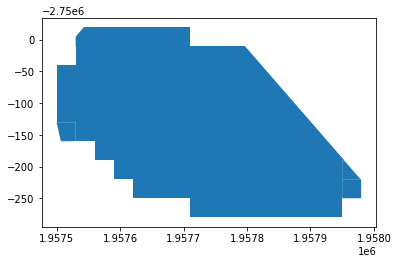

In [219]:
##  Form a shapely polygon from the coordinates defined by the user on the map
miniwit_roi = Polygon(roi[-1]['geometry']['coordinates'][0])

##  Generate a new geodataframe containing the user defined polygon geometry
miniwit_df = gpd.GeoDataFrame(gpd.GeoSeries(miniwit_roi), columns=['geometry'], crs='EPSG:4326')
miniwit_df = miniwit_df.to_crs(gdf.crs)

##  Intersect the user-defined region of interest with the master
##  to create the working gdf from which imagery will be extracted
miniwit_gdf = gpd.overlay(df_pxsummary1, miniwit_df, how='intersection')
print('This selection includes ', len(miniwit_gdf), ' individual polygons')
miniwit_gdf.plot()

In [220]:
# miniwit_gdf
# print(df_pxsummary1.head())
# print('-----')
# print(miniwit_gdf.head())
# df_pxsummary1.index

0
........


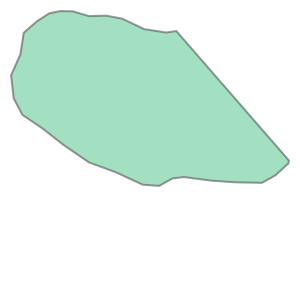

In [221]:
## Subsample the original gdf with the miniwit_df to extract the polygon class and unique polygon id to enable faster pixel searching within the corresponding xarray.
from pprint import pprint

polyid_gdf = gpd.overlay(miniwit_df, gdf, how='intersection')

## Check the number of class polygons that are included in the roi selection

for x in range(0,len(polyid_gdf['index'])):
    print (x)
    pprint(polyid_gdf.iloc[x]['geometry'])
    print ('........')

## If more than 1, check the shape matches your targeted class polygon by substituting
## x into the call to `polyid_gdf.iloc[]['geometry']` call

polyid_gdf.iloc[0]['geometry']

In [222]:
## Substitute the x value that represents your targeted polygon into the `pg = ...iloc[]['index']` call below to plot your pixel selection

## From the results2 dataset, the temporal values for the nominated polygon are stored in the following dataset of the resutls2 dict:
pg = polyid_gdf.iloc[0]['index']
## class key
cl = polyid_gdf.loc[polyid_gdf['index'] == pg].id.values.item()
## class polygon
# pg1 = polyid_gdf.loc[polyid_gdf['index'] == pg].index.values.item()
pg1 = polyid_gdf.loc[polyid_gdf['index'] == pg].key_0.values.item()

print('pg: ', pg, ' cl: ', cl, ' pg1: ', pg1)

pg:  3710  cl:  2  pg1:  9


In [223]:
## Now that I know my target polygon, I can intersect the geometries (somehow) of the pixel roi 
## with the pixels in the xarray and prepare them as per WIT above

mWIT = (results2[str(cl)][str(pg1)]).set_coords('geometry')

## 1D list of all geometries in class polygon of interest
a = mWIT['geometry'].stack(z=("y","x")).values

## list polygon bounds(coords)
aa = []
for polygon in a:
    aa.append(polygon.bounds)

## Record mWIT shapes
mw_yshape = mWIT.isel(time=0).dims['y']
mw_xshape = mWIT.isel(time=0).dims['x']
len_a = len(a)

## Confirm that 2D coords match with 1D (stacked) coords
f = mWIT['geometry'].values
print(f[0][0].bounds == a[0].bounds)   
print(f[0][-1].bounds == a[mw_xshape-1].bounds)  
print(f[-1][0].bounds == a[-mw_xshape].bounds)
print(f[-1][-1].bounds == a[-1].bounds) 

## 1D list of all geometries in pixels-roi
b = np.asarray(miniwit_gdf['geometry'].values)
len_b = len(b)

## list polygon bounds(coords)
bb=[]
for polygon in b:
    bb.append(polygon.bounds)

## Find matching pixels from roi in the class polygon
## For every pixel in the class polygon, compare against every pixel in roi.
## Store boolean results in px_df
px_ls = []

for val in bb:
#     print(val)
    for value in aa:
        px = np.all(np.isin(val,value))
        px_ls.append(px)

# reshape boolean results
px_array = np.array(px_ls)
px_array = px_array.reshape(len_b, len_a)#######
px_df = pd.DataFrame(px_array)

## Summarise px_df results into a single `array2`
## Record `True` for every pixel in the class polygon that also appears in the roi set of pixels. Else, record `False` 
array2 = []

for x in range(0,len(px_df.iloc[0])):
#     print (row)
    if np.any(px_df[x]) == True:
        array2.append('True')
    else:
        array2.append('False')
    
## Reshape and merge `array2` booleans into mWIT
mwpx_array = np.array(array2)
mwpx_array = mwpx_array.reshape(mw_yshape, mw_xshape)
mWIT['miniwit px'] = (('y', 'x'), mwpx_array)

## Mask mWIT to show only roi pixels
mWIT1 = mWIT.where(mWIT['miniwit px'] == 'True')

True
True
True
True


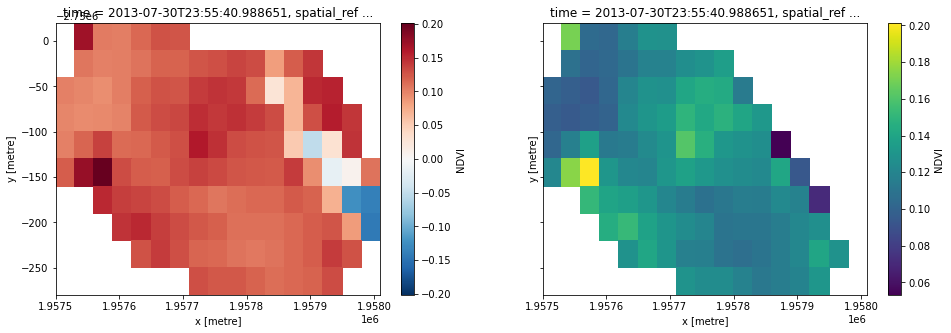

In [224]:
## Plot full class polygon vs the roi pixels
%matplotlib inline

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=[16,5])

mWIT.isel(time=0)['NDVI'].plot(ax=axes[0])
mWIT1.isel(time=0)['NDVI'].plot(ax=axes[1])

plt.draw()

In [ ]:
# miniwit time!!!!!